<a href="https://colab.research.google.com/github/abia200304/Distinct-Vehicle-Flow-Prediction-/blob/main/FinalSAEgridlstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -o /content/my_pems_data.zip


Archive:  /content/my_pems_data.zip
  inflating: my_pems_data/pems_station_500011021_flow_04-01-2024_0600_to_04-07-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-08-2024_0600_to_04-14-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-15-2024_0600_to_04-21-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-22-2024_0600_to_04-28-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-29-2024_0600_to_05-05-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-06-2024_0600_to_05-12-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-13-2024_0600_to_05-19-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-20-2024_0600_to_05-26-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-27-2024_0600_to_06-02-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_06-03-2024_0600_to_06-09-2024_0600.csv  
  inflating: m

Initial data loaded and scaled successfully.
Historic data shape: (14184, 2)
Recent data shape: (8640, 2)

--- Aligning Data for Model Input ---
Aligned Historic Train X shape: (6900, 15, 2)
Aligned Recent Train X shape: (6900, 15, 2)
Aligned Train Y shape: (6900, 2)
Aligned Historic Test X shape: (1725, 15, 2)
Aligned Recent Test X shape: (1725, 15, 2)
Aligned Test Y shape: (1725, 2)
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - loss: inf - mae: 0.4759 - mse: 0.5014 - val_loss: inf - val_mae: 0.1951 - val_mse: 0.0778
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: inf - mae: 0.1019 - mse: 0.0186 - val_loss: inf - val_mae: 0.1859 - val_mse: 0.0657
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: inf - mae: 0.0639 - mse: 0.0084 - val_loss: inf - val_mae: 0.1279 - val_mse: 0.0344
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: inf - mae: 0.0534 - mse: 0.0059 - val_loss: inf - val_mae: 0.1037 - val_mse: 0.0227
Epoch 5/50
184/184 ━━━━━━━━━

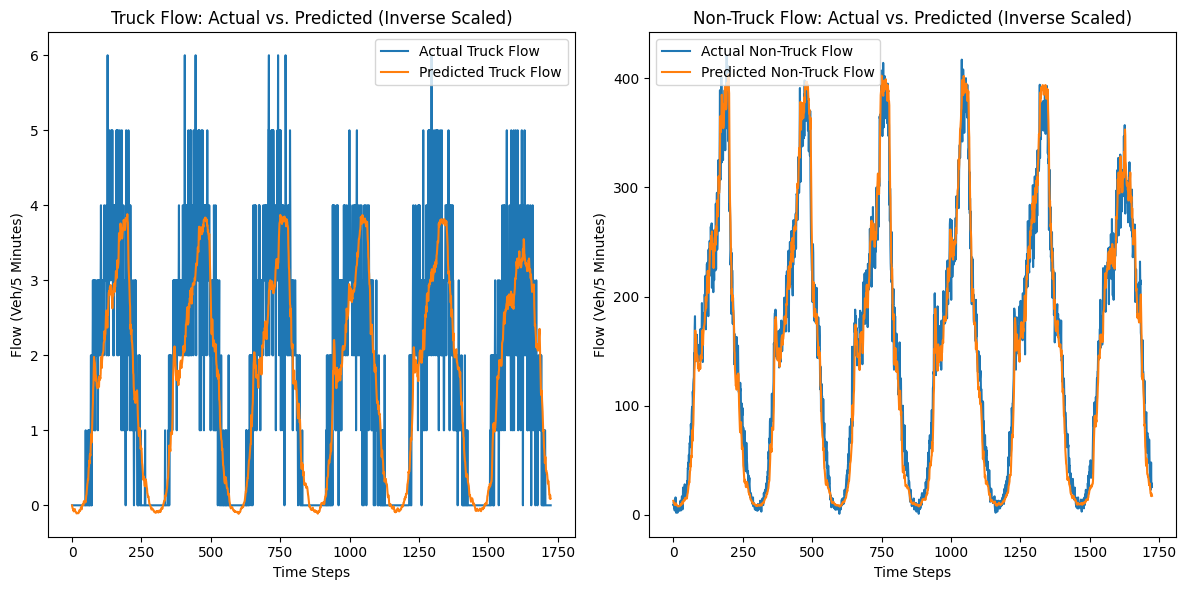

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout, BatchNormalization,
                                     Concatenate, TimeDistributed, MultiHeadAttention,
                                     LayerNormalization, Conv1D, GlobalAveragePooling1D, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from glob import glob


try:

    file_paths = glob('/content/my_pems_data/*.csv')
    all_data = []
    for file in file_paths:
        df_temp = pd.read_csv(file, delimiter='\t')
        df_temp.columns = df_temp.columns.str.strip()
        all_data.append(df_temp[['Flow (Veh/5 Minutes)', 'Truck Flow (Veh/5 Minutes)']])
    combined_df = pd.concat(all_data, ignore_index=True)
    processed_df = combined_df.rename(columns={'Flow (Veh/5 Minutes)': 'total_flow', 'Truck Flow (Veh/5 Minutes)': 'truck_flow'})
    processed_df['non_truck_flow'] = processed_df['total_flow'] - processed_df['truck_flow']
    processed_df.loc[processed_df['non_truck_flow'] < 0, 'non_truck_flow'] = 0
    data_unscaled = np.concatenate([
        processed_df['truck_flow'].values.reshape(-1, 1),
        processed_df['non_truck_flow'].values.reshape(-1, 1)
    ], axis=1)
    scaler = MinMaxScaler((0, 1))
    data = scaler.fit_transform(data_unscaled)
    print("Initial data loaded and scaled successfully.")
except Exception as e:
    print(f"Could not run placeholder data loading. Assuming 'data' and 'scaler' exist. Error: {e}")


#dataprep
samples_per_day = 288
recent_days = 30
recent_rows = samples_per_day * recent_days  # 288 * 30 = 8640

historic_data = data[:-recent_rows]  # first ~49 days
recent_data = data[-recent_rows:]    # last 30 days

print(f"Historic data shape: {historic_data.shape}")
print(f"Recent data shape: {recent_data.shape}")

def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 15
X_hist, Y_hist = create_dataset(historic_data, time_step)
X_recent, Y_recent = create_dataset(recent_data, time_step)

X_train_his = X_hist[:int(0.8*len(X_hist))]
y_train_his = Y_hist[:int(0.8*len(Y_hist))]

X_test_his = X_hist[int(0.8*len(X_hist)):]
y_test_his = Y_hist[int(0.8*len(Y_hist)):]

X_train_rec = X_recent[:int(0.8*len(X_recent))]
y_train_rec = Y_recent[:int(0.8*len(Y_recent))]

X_test_rec = X_recent[int(0.8*len(X_recent)):]
y_test_rec = Y_recent[int(0.8*len(Y_recent)):]

#making the x and y train same size
print("\n--- Aligning Data for Model Input ---")
min_train_len = min(len(X_train_his), len(X_train_rec))
min_test_len = min(len(X_test_his), len(X_test_rec))

X_train_his_aligned = X_train_his[-min_train_len:]
X_train_rec_aligned = X_train_rec[:min_train_len]
y_train_aligned = y_train_rec[:min_train_len]

X_test_his_aligned = X_test_his[-min_test_len:]
X_test_rec_aligned = X_test_rec[:min_test_len]
y_test_aligned = y_test_rec[:min_test_len]

print(f"Aligned Historic Train X shape: {X_train_his_aligned.shape}")
print(f"Aligned Recent Train X shape: {X_train_rec_aligned.shape}")
print(f"Aligned Train Y shape: {y_train_aligned.shape}")
print(f"Aligned Historic Test X shape: {X_test_his_aligned.shape}")
print(f"Aligned Recent Test X shape: {X_test_rec_aligned.shape}")
print(f"Aligned Test Y shape: {y_test_aligned.shape}")

#hybrid model(gridlstm +SAE+ATTENTION)
def build_hybrid_with_SAE(sequence_length=15, feature_dim=2,
                          encoding_dim=64, sparsity_level=0.05,
                          lambda_sparse=0.001):


    def sparse_activity_regularizer(activation):
        mean_act = tf.reduce_mean(activation, axis=0)
        mean_act = tf.clip_by_value(mean_act, 1e-8, 1 - 1e-8)
        kl_divergence = sparsity_level * tf.math.log(sparsity_level / mean_act) + (1 - sparsity_level) * tf.math.log((1 - sparsity_level) / (1 - mean_act))
        return lambda_sparse * tf.reduce_mean(kl_divergence) # Return mean instead of sum


    #Historic Path
    input_hist = Input(shape=(sequence_length, feature_dim), name='historical_input')
    hist_outputs = []
    for i in range(feature_dim):
        single_channel = input_hist[:, :, i:i+1]
        conv = Conv1D(32, 3, activation='relu', padding='same')(single_channel)
        lstm1 = layers.LSTM(64, return_sequences=True, dropout=0.2)(conv)
        lstm2 = layers.LSTM(32, return_sequences=True, dropout=0.2)(lstm1)
        hist_outputs.append(lstm2)
    hist_concat = Concatenate()(hist_outputs)
    hist_encoded = layers.LSTM(32, activation='relu', return_sequences=False,
                               kernel_regularizer=regularizers.l2(0.1))(hist_concat)

    # Recent Path
    input_recent = Input(shape=(sequence_length, feature_dim), name='recent_input')
    recent_dense = layers.TimeDistributed(Dense(sequence_length, activation='relu'))(input_recent)
    recent_encoded = layers.LSTM(64, activation='relu', return_sequences=False)(recent_dense)

    combined = Concatenate(name="dual_features")([hist_encoded, recent_encoded])
    expanded = Dense(sequence_length * feature_dim, activation="relu")(combined)
    reshaped = Reshape((sequence_length, feature_dim))(expanded)

    # SAE+attention mech

    x = Conv1D(16, 3, activation='relu', padding='same')(reshaped)
    x = BatchNormalization()(x)
    # x = Dropout(0.2)(x)

    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.2)(x)

    attn_out = MultiHeadAttention(num_heads=4, key_dim=32, dropout=0.1)(x, x)
    x = LayerNormalization()(x + attn_out)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)

    encoded = Dense(encoding_dim, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01),
                    activity_regularizer=sparse_activity_regularizer, # Add activity regularizer here
                    name="encoded")(x)

    # Decoder
    d = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(encoded)
    d = BatchNormalization()(d)
    # d = Dropout(0.3)(d)
    d = Dense(sequence_length * feature_dim, activation='linear')(d)
    decoded = Reshape((sequence_length, feature_dim), name="decoded")(d)
#prediction
    p = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(encoded)
    p = BatchNormalization()(p)
    # p = Dropout(0.4)(p)

    p = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(p)
    p = BatchNormalization()(p)
    # p = Dropout(0.3)(p)

    p = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(p)
    p = Dropout(0.2)(p)

    final_output = Dense(feature_dim, activation='linear', name='final_output',kernel_regularizer=regularizers.l2(0.1))(p)

    # ===== Define Models =====
    model = Model(inputs=[input_hist, input_recent],
                  outputs=final_output, name="Hybrid_SAE_Model")

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse', metrics=['mae','mse'])
    return model


# Define time_step before calling the model
time_step = 15
sparsity_level = 0.05
lambda_sparse = 0.001

# --- Build and Train ---
model = build_hybrid_with_SAE(sequence_length=time_step, feature_dim=2,
                              encoding_dim=64, sparsity_level=sparsity_level,
                              lambda_sparse=lambda_sparse)

history = model.fit(
    [X_train_his_aligned, X_train_rec_aligned],
    y_train_aligned,
    epochs=50,
    validation_split=0.15,
    verbose=1
)

# Evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
y_pred=model.predict([X_test_his_aligned, X_test_rec_aligned])
test_predict=model.predict([X_test_his_aligned, X_test_rec_aligned])


predictions_original_scale = scaler.inverse_transform(test_predict)
y_test_original_scale = scaler.inverse_transform(y_test_aligned)


actual_truck_flow = y_test_original_scale[:, 0]
predicted_truck_flow = predictions_original_scale[:, 0]

rmse_truck = np.sqrt(mean_squared_error(actual_truck_flow, predicted_truck_flow))
mae_truck = mean_absolute_error(actual_truck_flow, predicted_truck_flow)

# Masked MAPE
mask_truck = actual_truck_flow != 0
mape_truck = np.mean(
    np.abs((actual_truck_flow[mask_truck] - predicted_truck_flow[mask_truck]) / actual_truck_flow[mask_truck])
) * 100 if np.sum(mask_truck) > 0 else np.nan


print(f"--- Metrics for Truck Flow (Original Scale) ---")
print(f"RMSE: {rmse_truck:.4f}")
print(f"MAE: {mae_truck:.4f}")
print(f"MAPE (masked): {mape_truck:.2f}%")

actual_non_truck_flow = y_test_original_scale[:, 1]
predicted_non_truck_flow = predictions_original_scale[:, 1]

rmse_non_truck = np.sqrt(mean_squared_error(actual_non_truck_flow, predicted_non_truck_flow))
mae_non_truck = mean_absolute_error(actual_non_truck_flow, predicted_non_truck_flow)

# Masked MAPE
mask_non_truck = actual_non_truck_flow != 0
mape_non_truck = np.mean(
    np.abs((actual_non_truck_flow[mask_non_truck] - predicted_non_truck_flow[mask_non_truck]) / actual_non_truck_flow[mask_non_truck])
) * 100 if np.sum(mask_non_truck) > 0 else np.nan


print(f"\n--- Metrics for Non-Truck Flow (Original Scale) ---")
print(f"RMSE: {rmse_non_truck:.4f}")
print(f"MAE: {mae_non_truck:.4f}")
print(f"MAPE (masked): {mape_non_truck:.2f}%")


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.figure(figsize=(12, 6))

#  Truck Flow
plt.subplot(1, 2, 1)
plt.plot(y_test_original_scale[:, 0], label='Actual Truck Flow')
plt.plot(predictions_original_scale[:, 0], label='Predicted Truck Flow')
plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

# Non-Truck Flow
plt.subplot(1, 2, 2)
plt.plot(y_test_original_scale[:, 1], label='Actual Non-Truck Flow')
plt.plot(predictions_original_scale[:, 1], label='Predicted Non-Truck Flow')
plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('SAEgridlstm.keras')

In [ ]:
# import tensorflow as tf

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# converter._experimental_lower_tensor_list_ops = False
# tflite_model = converter.convert()

# # Save to .tflite file
# with open('SAEgridlstm_model_quant.tflite', 'wb') as f:
#     f.write(tflite_model)

In [ ]:
# from google.colab import files

# # Download the quantized model
# files.download("SAEgridlstm_model_quant.tflite")